In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x "/content/drive/MyDrive/data_1min_p.rar" "/content/content/data_1min/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/data_1min_p.rar

Creating    /content/content                                          OK
Creating    /content/content/data_1min                                OK
Extracting  /content/content/data_1min/TONUSDT.pickle                      0%  1%  OK 
Extracting  /content/content/data_1min/ETHUSDT.pickle                      2%  3%  OK 
Extracting  /content/content/data_1min/EIGENUSDT.pickle                    3%  4%  OK 
Extracting  /content/content/data_1min/ARBUSDT.pickle                      5%  OK 
Extracting  /content/content/data_1min/PENGUUSDT.pickle                    6%  7%  OK 
Extracting  /content/content/data_1min/ENAUSDT.pickle                      8%  OK 
Extracting  /content/content/data_1min/1000BONKUSDT.pickle                 9% 10%  OK 
Extracting  /content/content/data_1min

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Loading OHLCV of multi stocks

In [4]:
import os
# data_crypto_path = '/content/content2/'
# list_crypto = [x[5:-4] for x in os.listdir(data_crypto_path) if 'data_' in x and 'FORMUSDT' not in x]

data_crypto_path = '/content/content/data_1min/'
list_crypto = [x[:-7] for x in os.listdir(data_crypto_path)]
# list_crypto = list_crypto[4:10]
# list_crypto = list_crypto[:10] + list_crypto[-10:]
len(list_crypto)

75

Loading Embeded news based on bigbird

In [ ]:
df_news_main = pd.read_pickle('/content/drive/MyDrive/news.pickle')

dfff = df_news_main[[x[:-4] for x in list_crypto if x[:-4] in df_news_main.columns]].sum().sort_values(ascending=False).iloc[:30]
list_crypto = list(dfff.index)
list_crypto = [x+'USDT' for x in list_crypto]

df_news_main['news_count'] = df_news_main[[x[:-4] for x in list_crypto]].sum(axis=1)
df_news_main = df_news_main[df_news_main['news_count']>0].copy()
df_news_main

Get No news Embedding

In [5]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# === Config ===
MODEL_PATH = "/content/drive/MyDrive/ColabModels/bigbird-2048-final"
BATCH_SIZE = 32
MAX_LEN = 2048
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load model & tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModel.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()  # No dropout

# === Embedding function ===
def get_embeddings(texts):
    """Tokenize and get embeddings for a batch of texts."""
    enc = tokenizer(
        texts,
        truncation=True,
        padding="max_length",  # Ensures same shape for batching
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        # Use CLS token embedding (first token)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu()
    return embeddings


no_news_embedding = get_embeddings(["no news at this time"]).cpu().numpy()[0]

Preparing embedding of news (Handling multi news and no news)

In [9]:
import pandas as pd
import numpy as np

def _parse_to_dt(s):
    """Parse timestamps; handles ms-epoch or datetime-like strings."""
    # try ms epoch first
    dt_ms = pd.to_datetime(s, unit="ms", errors="coerce")
    if getattr(dt_ms, "notna", lambda: False)().mean() > 0.9:
        return dt_ms
    return pd.to_datetime(s, errors="coerce")

def _avg_embeddings(series):
    """Average a Series of embeddings (lists/np arrays) into one np array."""
    arrs = []
    for x in series:
        if x is None:
            continue
        if isinstance(x, (list, tuple)):
            x = np.asarray(x, dtype=float)
        elif isinstance(x, np.ndarray):
            x = x.astype(float, copy=False)
        else:
            # skip non-array values
            continue
        arrs.append(x)
    if not arrs:
        return None
    # Ensure same length
    lens = {a.shape for a in arrs}
    if len(lens) != 1:
        raise ValueError(f"Embedding length mismatch in group: shapes={lens}")
    return np.mean(np.stack(arrs, axis=0), axis=0)

def resample_news_to_3min(df_news, no_news_embedding, rule="3T"):
    """
    Resample df_news to 3-min bins:
      - embedding: mean over bin
      - per-asset columns (0/1): sum -> count of related news per asset
      - news_count: sum if present; else group size
    Returns a DataFrame indexed by 3-min timestamps with filled 'no news' rows.
    """
    df = df_news.copy()

    # Identify columns
    base_cols = {"releasedAt", "embedding", "news_count"}
    # infer asset columns as 0/1 flags (all the rest)
    asset_cols = [c for c in df.columns if c not in base_cols]

    # Parse releasedAt and floor to 3-min
    df["releasedAt"] = _parse_to_dt(df["releasedAt"])
    df = df.dropna(subset=["releasedAt"])
    df["t3"] = df["releasedAt"].dt.floor(rule)
    df = df.sort_values("t3")

    # Build aggregation dict
    agg_dict = {c: "sum" for c in asset_cols}  # counts per asset
    if "news_count" in df.columns:
        agg_dict["news_count"] = "sum"

    # Group and aggregate
    g = df.groupby("t3", sort=True)
    news_agg = g.agg(agg_dict)
    # If news_count not provided, use group size as total count
    if "news_count" not in news_agg.columns:
        news_agg["news_count"] = g.size()

    # Embedding: custom mean
    emb_mean = g["embedding"].apply(_avg_embeddings)
    news_agg = news_agg.join(emb_mean.rename("embedding"))

    # Ensure integer dtype for asset counts
    for c in asset_cols:
        if c in news_agg.columns:
            news_agg[c] = news_agg[c].fillna(0).astype(int)

    # Fill missing bins **within the observed range** (optional; often we reindex to market later)
    full_index = pd.date_range(news_agg.index.min(), news_agg.index.max(), freq=rule)
    news_agg = news_agg.reindex(full_index)

    # Fill 'no news' bins: zero counts, no_news_embedding
    news_agg["news_count"] = news_agg["news_count"].fillna(0).astype(int)
    for c in asset_cols:
        news_agg[c] = news_agg[c].fillna(0).astype(int)

    # Fill embeddings where NaN with the provided no-news vector
    if no_news_embedding is None:
        raise ValueError("no_news_embedding must be provided (list or np.array).")
    no_news_embedding = np.asarray(no_news_embedding, dtype=float)
    mask = news_agg["embedding"].isna()
    news_agg.loc[mask, "embedding"] = news_agg.loc[mask, "embedding"].apply(
        lambda _: np.asarray(no_news_embedding, dtype=float).copy()
    )


    news_agg.index.name = "t3"
    return news_agg

def merge_news_into_market(df_market, news_3m, rule="3T", date_col="dateTime"):
    """
    Merge resampled news into market dataframe on 3-min bins.
    - df_market[date_col] can be ms-epoch or datetime-like; we floor to 3T.
    - Returns df_market with added columns: embedding, news_count, and per-asset counts.
    """
    dm = df_market.copy()

    # Parse/normalize market times → 3-min bins
    if not np.issubdtype(dm[date_col].dtype, np.datetime64):
        dt_ms = pd.to_datetime(dm[date_col], unit="ms", errors="coerce")
        if dt_ms.notna().mean() > 0.9:
            dm[date_col] = dt_ms
        else:
            dm[date_col] = pd.to_datetime(dm[date_col], errors="coerce")
    dm = dm.dropna(subset=[date_col]).sort_values(date_col)
    dm["t3"] = dm[date_col].dt.floor(rule)

    # Reindex news to exactly the market timestamps so every market row gets a match
    needed_index = dm["t3"].unique()
    news_for_market = news_3m.reindex(needed_index)

    # (Safety) Any remaining missing embeddings -> fill with first non-null or leave None
    if news_for_market["embedding"].isna().any():
        # better to leave them NaN if you want to detect them later
        pass

    # Merge
    out = dm.merge(
        news_for_market.reset_index().rename(columns={"t3": "t3_news"}),
        left_on="t3",
        right_on="t3_news",
        how="left",
        suffixes=("", "_news"),
    ).drop(columns=["t3_news"])

    return out

# ----------------------
# Usage:
# news_3m = resample_news_to_3min(df_news, no_news_embedding, rule="3T")
# merged  = merge_news_into_market(df_market, news_3m, rule="3T", date_col="dateTime")


In [ ]:
df_news = df_news_main[['releasedAt','embedding','news_count']+[x[:-4] for x in list_crypto]].copy()
news_3m = resample_news_to_3min(df_news, no_news_embedding, rule="3T")

Preprocessing OHLCV

In [13]:
list_data = []
shifted_window = 80
selected_f_asset = ['open', 'high', 'low', 'close', 'volume',
    'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol']
selected_f_asset = ['close', 'volume', 'numberOfTrades', 'prev_return', 'prev_volatility', 'return', 'volatility']
# selected_f_asset = ['close', 'volume', 'numberOfTrades', 'quoteAssetVolume', 'takerBuyBaseVol', 'takerBuyQuoteVol','return']
selected_f_all = []
list_target = []

for symb in list_crypto:
  df = pd.read_pickle(data_crypto_path+'{}.pickle'.format(symb))
  df = df.set_index('dateTime').resample('3T').agg({
        "open": "first",
        "high": "max",
        "low":  "min",
        "close":"last",
        "volume": "sum",
        "quoteAssetVolume": "sum",
        "numberOfTrades": "sum",
        "takerBuyBaseVol": "sum",
        "takerBuyQuoteVol": "sum",
        # "closeTime": "last",  # we'll recompute below to be exact
        "ignore": "last"
    }).reset_index()
  print(symb, len(df))
  df['return'] = 100*((df['close'].shift(-1)/df['close'])-1)
  df['prev_return'] = 100*((df['close']/df['close'].shift(shifted_window))-1)
  df['volatility'] = 100*df['close'].rolling(shifted_window).std().shift(-shifted_window)
  df['prev_volatility'] = 100*df['close'].rolling(shifted_window).std()
  df = df[selected_f_asset].rename(columns={x:symb+'_'+x for x in selected_f_asset})
  selected_f_all.extend(list(df.columns))

  df[symb+'_return'] = df[symb+'_'+'return']
  df[symb+'_volatility'] = df[symb+'_'+'volatility']
  list_target.append(symb+'_return')
  list_target.append(symb+'_volatility')
  list_data.append(df.copy())

BTCUSDT 80161
ETHUSDT 80161
XRPUSDT 80161
SOLUSDT 80161
DOGEUSDT 80161
ADAUSDT 80161
TRUMPUSDT 80161
SHIBUSDT 80161
BNBUSDT 80161
USDCUSDT 80161
PEPEUSDT 80161
LINKUSDT 80161
AVAXUSDT 80161
SUIUSDT 80161
XLMUSDT 80161
LTCUSDT 80161
HBARUSDT 80161
PENGUUSDT 80161
DOTUSDT 80161
UNIUSDT 80161
OPUSDT 80161
TRXUSDT 80161
ARBUSDT 80161
APTUSDT 80161
TONUSDT 80161
ATOMUSDT 80161
BONKUSDT 80161
AAVEUSDT 80161
BCHUSDT 80161
ONDOUSDT 80161


In [14]:
data = pd.concat(list_data,axis=1)
df = pd.read_pickle(data_crypto_path+'{}.pickle'.format('BTCUSDT'))
df = df.set_index('dateTime').resample('3T').agg({
      "open": "first",
      "high": "max",
      "low":  "min",
      "close":"last",
      "volume": "sum",
      "quoteAssetVolume": "sum",
      "numberOfTrades": "sum",
      "takerBuyBaseVol": "sum",
      "takerBuyQuoteVol": "sum",
      # "closeTime": "last",  # we'll recompute below to be exact
      "ignore": "last"
  }).reset_index()
df['return'] = df['close'].pct_change()
data['dateTime'] = df['dateTime']
data['time'] = data['dateTime'].astype(str).copy()
data['return'] = df['close'].pct_change()
data

,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_numberOfTrades,BTCUSDT_prev_return,BTCUSDT_prev_volatility,BTCUSDT_return,BTCUSDT_volatility,ETHUSDT_close,ETHUSDT_volume,ETHUSDT_numberOfTrades,...,ONDOUSDT_close,ONDOUSDT_volume,ONDOUSDT_numberOfTrades,ONDOUSDT_prev_return,ONDOUSDT_prev_volatility,ONDOUSDT_return,ONDOUSDT_volatility,dateTime,time,return
0,88576.6,687.785,10675,NaN,NaN,-0.078463,34425.588501,2497.69,7141.740,10497,...,1.0047,447930.4,1833,NaN,NaN,-0.537474,0.819794,2025-02-26 00:00:00,2025-02-26 00:00:00,NaN
1,88507.1,603.665,7962,NaN,NaN,0.048471,34542.567484,2491.67,6647.830,10633,...,0.9993,567530.5,1812,NaN,NaN,-0.350245,0.817664,2025-02-26 00:03:00,2025-02-26 00:03:00,-0.000785
2,88550.0,219.852,5441,NaN,NaN,-0.160361,34780.275386,2490.75,15111.279,13290,...,0.9958,1416951.1,3808,NaN,NaN,0.070295,0.820485,2025-02-26 00:06:00,2025-02-26 00:06:00,0.000485
3,88408.0,536.513,6205,NaN,NaN,0.048073,34826.656321,2485.56,13124.788,12112,...,0.9965,325510.9,1206,NaN,NaN,-0.240843,0.823190,2025-02-26 00:09:00,2025-02-26 00:09:00,-0.001604
4,88450.5,224.461,4530,NaN,NaN,-0.034370,34861.771950,2486.74,13028.360,10062,...,0.9941,473624.9,1452,NaN,NaN,-0.251484,0.825619,2025-02-26 00:12:00,2025-02-26 00:12:00,0.000481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80156,118674.0,112.568,3051,-0.290624,18083.461542,0.090079,NaN,4225.80,2716.411,5218,...,0.9857,51114.3,517,-1.272035,0.734577,-0.030435,NaN,2025-08-11 23:48:00,2025-08-11 23:48:00,-0.000253
80157,118780.9,155.130,3380,0.082573,18091.237275,-0.086041,NaN,4226.50,3044.104,5525,...,0.9854,126264.9,501,-0.695354,0.736758,-0.030444,NaN,2025-08-11 23:51:00,2025-08-11 23:51:00,0.000901
80158,118678.7,105.195,2801,-0.085788,18084.739502,-0.031008,NaN,4226.08,3532.942,6106,...,0.9851,98157.5,477,-1.034760,0.737341,-0.182723,NaN,2025-08-11 23:54:00,2025-08-11 23:54:00,-0.000860
80159,118641.9,51.928,1636,-0.330490,17747.989444,0.030343,NaN,4221.31,2938.447,4933,...,0.9833,103772.5,631,-1.463072,0.736899,0.091529,NaN,2025-08-11 23:57:00,2025-08-11 23:57:00,-0.000310


Merging news and ohlcv

In [15]:
data  = merge_news_into_market(data, news_3m, rule="3T", date_col="dateTime")

Creating list of days for splitting data

In [ ]:
data['day'] = data['dateTime'].apply(lambda x:str(x)[:10])

0.5628797045945035

In [18]:
list(data['day'].unique())
list_days = list(data['day'].unique())
list_days_train = list_days[:int(0.77*len(list_days))]
list_days_valid = list_days[int(0.77*len(list_days)):int(0.88*len(list_days))]
list_days_test = list_days[int(0.88*len(list_days)):]

In [19]:
data_all = data[~data['day'].isin(list_days_test)].copy()
data_all = data.copy()

In [20]:
list_crypto_first = [x[:-4] for x in list_crypto]
len(list_crypto_first)

30

Removing nan part of data

In [22]:
data_all = data_all.iloc[100:-100].copy()

Normalizing Data Z-Score

In [23]:
##Normalization
list_normalizing = []
for x in selected_f_all:
  if(x not in list_target):
    data_all[x] = data_all[x].fillna(0)
    data_all[x] = data_all[x].astype(float)
    list_normalizing.append({x:{'mean':data_all[x].mean(), 'std':data_all[x].std()}})
    data_all[x] = (data_all[x]-data_all[x].mean())/(data_all[x].std())


Save and Load normalizing variables

In [24]:
import pickle

# my_list = [1, 2, 3, 'apple', {'a': 10}]
with open('/content/drive/MyDrive/portfolio_novo/normalizing_config_mofn_3min_perp.pkl', 'wb') as f:
    pickle.dump(list_normalizing, f)

with open('/content/drive/MyDrive/portfolio_novo/normalizing_config_mofn_3min_perp.pkl', 'rb') as f:
    loaded_list = pickle.load(f)

print(loaded_list)


[{'BTCUSDT_close': {'mean': np.float64(99935.40110428835), 'std': 12722.971842647166}}, {'BTCUSDT_volume': {'mean': np.float64(386.16266182263854), 'std': 598.2167094178158}}, {'BTCUSDT_numberOfTrades': {'mean': np.float64(6764.290991858531), 'std': 8190.489304207392}}, {'BTCUSDT_prev_return': {'mean': np.float64(0.03445154860271861), 'std': 0.9340718421065288}}, {'BTCUSDT_prev_volatility': {'mean': np.float64(28140.429000269916), 'std': 22321.248681509554}}, {'ETHUSDT_close': {'mean': np.float64(2452.7579903953174), 'std': 669.1936863057207}}, {'ETHUSDT_volume': {'mean': np.float64(12641.914893172921), 'std': 18270.722248631086}}, {'ETHUSDT_numberOfTrades': {'mean': np.float64(11521.93769462613), 'std': 11496.266438846033}}, {'ETHUSDT_prev_return': {'mean': np.float64(0.06719693808976368), 'std': 1.5735038021609014}}, {'ETHUSDT_prev_volatility': {'mean': np.float64(1217.9800518507213), 'std': 955.5367332761357}}, {'XRPUSDT_close': {'mean': np.float64(2.40694215930266), 'std': 0.388274

Create time index for TimseNet

In [25]:
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset, DataLoader

df_stamp = data_all[['time']].rename(columns={'time':'dateTime'})
df_stamp['dateTime'] = pd.to_datetime(df_stamp['dateTime'])
df_stamp['month'] = df_stamp.dateTime.apply(lambda row: row.month, 1)
df_stamp['day'] = df_stamp.dateTime.apply(lambda row: row.day, 1)
df_stamp['weekday'] = df_stamp.dateTime.apply(lambda row: row.weekday(), 1)
df_stamp['hour'] = df_stamp.dateTime.apply(lambda row: row.hour, 1)
df_stamp['minute'] = df_stamp.dateTime.apply(lambda row: row.minute, 1)
data_stamp = df_stamp.drop(['dateTime'], axis=1)

Dataset Class and Creating DataLoader

In [26]:
selected_f_all = [x for x in selected_f_all if (('return' not in x) or ('prev_return' in x))]
selected_f_all = [x for x in selected_f_all if (('volatility' not in x) or ('prev_volatility' in x))]
seleted_crypto = [x[:-4] for x in list_crypto]
selected_f_all

['BTCUSDT_close',
 'BTCUSDT_volume',
 'BTCUSDT_numberOfTrades',
 'BTCUSDT_prev_return',
 'BTCUSDT_prev_volatility',
 'ETHUSDT_close',
 'ETHUSDT_volume',
 'ETHUSDT_numberOfTrades',
 'ETHUSDT_prev_return',
 'ETHUSDT_prev_volatility',
 'XRPUSDT_close',
 'XRPUSDT_volume',
 'XRPUSDT_numberOfTrades',
 'XRPUSDT_prev_return',
 'XRPUSDT_prev_volatility',
 'SOLUSDT_close',
 'SOLUSDT_volume',
 'SOLUSDT_numberOfTrades',
 'SOLUSDT_prev_return',
 'SOLUSDT_prev_volatility',
 'DOGEUSDT_close',
 'DOGEUSDT_volume',
 'DOGEUSDT_numberOfTrades',
 'DOGEUSDT_prev_return',
 'DOGEUSDT_prev_volatility',
 'ADAUSDT_close',
 'ADAUSDT_volume',
 'ADAUSDT_numberOfTrades',
 'ADAUSDT_prev_return',
 'ADAUSDT_prev_volatility',
 'TRUMPUSDT_close',
 'TRUMPUSDT_volume',
 'TRUMPUSDT_numberOfTrades',
 'TRUMPUSDT_prev_return',
 'TRUMPUSDT_prev_volatility',
 'SHIBUSDT_close',
 'SHIBUSDT_volume',
 'SHIBUSDT_numberOfTrades',
 'SHIBUSDT_prev_return',
 'SHIBUSDT_prev_volatility',
 'BNBUSDT_close',
 'BNBUSDT_volume',
 'BNBUSDT_numbe

In [27]:
shifted_window

80

In [28]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import Dataset, DataLoader

class NewsTimeSeriesDataset(Dataset):
    def __init__(self, df, data_stamp, selected_f_all, stock_list, seq_len=30):
        self.df = df.reset_index(drop=True)
        self.data_stamp = data_stamp.reset_index(drop=True)
        self.features = selected_f_all
        self.seq_len = seq_len
        self.stock_list = [x+'_return' for x in stock_list]

    def __len__(self):
        return len(self.df) - self.seq_len-shifted_window

    def __getitem__(self, idx):
        ts_window = self.df.loc[idx:idx + self.seq_len - 1, self.features].values.astype('float32')
        nc_window = self.df.loc[idx:idx + self.seq_len - 1, seleted_crypto].values.astype('float32')
        # x_mask = self.data_stamp.loc[idx:idx + self.seq_len - 1].values.astype('float32')
        news_window = self.df.loc[idx:idx + self.seq_len - 1, 'embedding'].values
        news_window = np.stack(news_window).astype('float32')
        target = self.df.loc[idx + self.seq_len:idx + self.seq_len+shifted_window-1, self.stock_list].values.astype('float32')  # shape: [19]
        return {
            'timeseries': torch.tensor(ts_window),     # [30, 114]
            'news': torch.tensor(news_window),         # [30, 768]
            'target': torch.tensor(target),
            'news_count':torch.tensor(nc_window)# [19]
        }

my_seq_len = 80
split = int(0.8 * len(data_all))

data_train = data_all[data_all['day'].isin(list_days_train)].copy()
data_test = data_all[data_all['day'].isin(list_days_valid)].copy()
train_dataset = NewsTimeSeriesDataset(data_train, data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=my_seq_len)
val_dataset = NewsTimeSeriesDataset(data_test, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [29]:
data_train[selected_f_all].shape

(61820, 150)

In [31]:
len(list_crypto)

30

Loss Function and Validation Func (for m of n and also n of n)

In [32]:
import torch
import torch.nn.functional as F

def weights_long_short_topk_abs(logits, k, gross=1.0, eps=1e-8):
    """
    logits: [B, N] real scores from the network
    k:      number of active positions (e.g., 10 of 30)
    gross:  target gross exposure sum(|w|) (e.g., 1.0)
    returns w: [B, N] signed weights, |w| sum to gross, exactly k nonzeros
    """
    B, N = logits.shape
    # map to signed scores in [-1, 1]
    s = torch.tanh(logits)

    if (k is None) or (k >= N):
        # use all assets, L1-normalize to gross
        denom = s.abs().sum(dim=1, keepdim=True).clamp_min(eps)
        return gross * s / denom

    # select top-k by absolute magnitude
    _, idx = torch.topk(s.abs(), k=k, dim=1)
    mask = torch.zeros_like(s, dtype=torch.bool)
    mask.scatter_(1, idx, True)

    s_mask = torch.where(mask, s, torch.zeros_like(s))
    denom = s_mask.abs().sum(dim=1, keepdim=True).clamp_min(eps)
    w = gross * s_mask / denom
    return w

def loss_topk_longshort(
    logits,                # [B, N]
    target,                # [B, T, N] realized returns
    k=10,                  # active names
    gross=1.0,             # sum(|w|) cap
    use_cov=True,         # False: std(r_p) ; True: w^T Σ w
    lambda_div=0.01,       # diversification (L2 on weights magnitude)
    lambda_net=0.0,        # net exposure penalty toward 0
    lambda_turnover=0.0,   # optional: needs prev_w (see note)
    prev_w=None,
    eps=1e-6
):
    B, T, N = target.shape
    w = weights_long_short_topk_abs(logits, k=k, gross=gross)  # [B, N]

    # portfolio returns per time step
    r_p = (w.unsqueeze(1) * target).sum(dim=2)  # [B, T]

    if use_cov:
        # risk via covariance: var_p = w^T Σ w, Σ estimated over T
        centered = target - target.mean(dim=1, keepdim=True)     # [B,T,N]
        # Σ_b = (X^T X)/(T-1)
        cov = centered.transpose(1, 2) @ centered / max(T-1, 1)  # [B,N,N]
        # var_p_b = w_b^T Σ_b w_b
        var_p = torch.einsum("bi,bij,bj->b", w, cov, w).clamp_min(eps)
        mean_r = r_p.mean(dim=1)
        risk = var_p.sqrt()
    else:
        mean_r = r_p.mean(dim=1)
        risk = r_p.std(dim=1).clamp_min(eps)

    sharpe = mean_r / risk
    loss_sharpe = -sharpe.mean()

    # Regularizers
    loss_div = (w**2).sum(dim=1).mean()                          # discourage over-concentration
    loss_net = (w.sum(dim=1)**2).mean()                          # push net exposure ~ 0
    if (lambda_turnover > 0.0) and (prev_w is not None):
        # encourage smoothness over time (expects prev_w: [B, N])
        loss_to = (w - prev_w).abs().sum(dim=1).mean()
    else:
        loss_to = torch.tensor(0.0, device=logits.device)

    return loss_sharpe + lambda_div*loss_div + lambda_net*loss_net + lambda_turnover*loss_to

@torch.no_grad()
def validate_longshort(logits, target, k=10, gross=1.0, use_cov=True):
    w = weights_long_short_topk_abs(logits, k=k, gross=gross)
    r_p = (w.unsqueeze(1) * target).sum(dim=2)  # [B,T]
    if use_cov:
        centered = target - target.mean(dim=1, keepdim=True)
        cov = centered.transpose(1,2) @ centered / max(target.shape[1]-1, 1)
        var_p = torch.einsum("bi,bij,bj->b", w, cov, w).clamp_min(1e-6)
        mean_r = r_p.mean(dim=1)
        sharpe = mean_r / var_p.sqrt()
    else:
        mean_r = r_p.mean(dim=1)
        sharpe = mean_r / r_p.std(dim=1).clamp_min(1e-6)
    return mean_r, sharpe, w



Model Architecture

In [33]:
import math
import torch.nn as nn
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerReturnPredictor(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=4, num_layers=2, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, feature_dim]
        x = self.input_proj(x)             # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)            # Add positional encoding
        x = self.transformer(x)            # [batch_size, seq_len, d_model]
        x = x[:, -1, :]                    # Use representation of last time step
        return self.output_layer(x).squeeze(-1)


In [34]:
data_all['embedding'].iloc[0].shape

(768,)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from transformers import AutoTokenizer, AutoModel
finbert_model_name = "yiyanghkust/finbert-tone"
import torch.nn as nn

class MarketNewsFusionModel(nn.Module):
    def __init__(self, ts_input_dim, hidden_dim=64, num_stocks=19,
                 max_len=30, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.num_stocks = num_stocks

        self.d_model = d_model
        self.input_proj = nn.Linear(ts_input_dim, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ts_out = nn.Linear(128, hidden_dim)
        news_embed_dim = 768

        # 2. News LSTM
        self.news_proj = nn.Linear(news_embed_dim, 64)
        self.news_lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, batch_first=True)

        # self.news_proj = nn.Linear(news_embed_dim, 64)
        self.count_lstm = nn.LSTM(input_size=len(seleted_crypto), hidden_size=len(seleted_crypto), batch_first=True)

        # 3. Stock-specific regression heads (1 per stock)
        self.stock_heads = nn.Sequential(
                nn.Linear(self.d_model+hidden_dim+len(seleted_crypto), 64),
                nn.ReLU(),
                nn.Linear(64, num_stocks)
            )

    def forward(self, ts_input, nc_input,news_input, x_mark_enc):  # [B, 30, F], [B, 30, E]

                # Transformer on OHLCV
        x = self.input_proj(ts_input)           # [B, T, d_model]
        x = self.pos_encoder(x)
        x = self.transformer(x)                  # [B, T, d_model]
        ts_emb = x[:, -1, :].squeeze(1)                   # [B, d_model]


        news_proj = self.news_proj(news_input)         # [B, 30, 64]
        _, (hn, _) = self.news_lstm(news_proj)        # hn: [1, B, 64]
        news_emb = hn[-1]

        _, (hc, _) = self.count_lstm(nc_input)
        nc_emb = hc[-1]                        # [B, 64]

        fused = torch.cat([ts_emb, news_emb, nc_emb], dim=1)   # [B, 128]
        # print(fused.shape)

        outputs = self.stock_heads(fused).squeeze(-1)
        return outputs             # [B, 19]


seq_len = my_seq_len

# model = TimesNet.Model(args).float()
# model = Model_TimesNet(configs).float()

In [36]:
data_all = data_all.fillna(0)

In [37]:
seq_len

80

Loading Model and dataloader

In [38]:
from torch.utils.data import DataLoader

# Example setup
# selected_f_all = list of feature columns (e.g., 6 × 19 = 114)
# stock_list = ['AAPL', 'GOOG', ..., 'TSLA'] → 19 stock target columns
# df = your dataframe with those columns and 'embedding' column


split = int(0.8 * len(data_all))

# train_dataset = NewsTimeSeriesDataset(data_all.iloc[:split], data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=30)
# val_dataset = NewsTimeSeriesDataset(data_all.iloc[split:], data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=30)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)
data_train = data_all[data_all['day'].isin(list_days_train)].copy()
data_val   = data_all[data_all['day'].isin(list_days_valid)].copy()
data_test  = data_all[data_all['day'].isin(list_days_test)].copy()

train_dataset = NewsTimeSeriesDataset(data_train, data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=my_seq_len)
val_dataset   = NewsTimeSeriesDataset(data_val, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)
test_dataset  = NewsTimeSeriesDataset(data_test, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()



Using device: cuda


In [39]:
len(selected_f_all)

150

Testing model pipeline

In [40]:
top_k = 30

# One training step
for batch in val_loader:
    ts_input = batch['timeseries'].to(device)
    news_input = batch['news'].cuda()
    target = batch['target'].to(device)
    news_count = batch['news_count'].cuda()
    time_mask = 1
    output = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
    loss = loss_topk_longshort(output, target, k=top_k, gross=1.0, use_cov=True, lambda_div=0.01, lambda_net=0, lambda_turnover=0,  prev_w=None, eps=1e-6)
    # Validation
    mean_r, sharpe, w = validate_longshort(output, target, k=top_k, gross=1.0, use_cov=True)
    print(ts_input.shape)
    print(w[0])
    print(mean_r[0], sharpe[0])
    break

torch.Size([32, 80, 150])
tensor([ 0.0077, -0.0267,  0.0469, -0.0702, -0.0253,  0.0332,  0.0383, -0.0204,
         0.0388, -0.0308,  0.0263,  0.0205, -0.0463, -0.0091,  0.0742, -0.0223,
         0.0257, -0.0731, -0.0651, -0.0428,  0.0438, -0.0503, -0.0039,  0.0005,
         0.0443,  0.0648, -0.0009,  0.0055,  0.0374,  0.0047], device='cuda:0')
tensor(-0.0011, device='cuda:0') tensor(-0.0422, device='cuda:0')


Creating and plotting portfolio

In [41]:
import matplotlib.pyplot as plt



def func_generate_portfolio(all_preds, data_portfo=data_test, seq_len=my_seq_len):
  predicted_weight = np.vstack(all_preds)

  df_weight_pred = data_portfo[my_seq_len:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()
  df_return = data_portfo[my_seq_len:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()
  list_weight = []
  for i in range(len(list_crypto)):
    df_weight_pred[list_crypto[i]+'_weight'] = predicted_weight[:,i]
    list_weight.append(list_crypto[i]+'_weight')


  sum_weight = abs(df_weight_pred[list_weight]).sum(axis=1).copy()
  for x in list_weight:
    df_weight_pred[x] = df_weight_pred[x]/sum_weight

  df_weight_pred.to_pickle('/content/drive/MyDrive/portfolio_novo/7of20stock_df_weight_pred_epoch{}.pickle'.format(str(epoch)))

  df_weight_30 = df_weight_pred[['dateTime']+list(df_weight_pred.columns[-len(list_weight):])].iloc[::my_seq_len].reset_index().drop('index',axis=1)
  df_portfolio = df_return.merge(df_weight_30, on='dateTime', how='left')
  df_portfolio = df_portfolio.fillna(method='ffill')
  list_portfolio = []
  for x in list_crypto:
    df_portfolio[x+'_value'] = df_portfolio[x+'_weight']*df_portfolio[x+'_return']
    list_portfolio.append(x+'_value')
  df_portfolio['portfolio_return'] = df_portfolio[list_portfolio].sum(axis=1)
  df_portfolio['portfolio'] = df_portfolio[list_portfolio].cumsum().sum(axis=1)
  df_portfolio.to_pickle('/content/drive/MyDrive/portfolio_novo/7of20stock_df_portfolio_epoch{}.pickle'.format(str(epoch)))

  # Example: Plot df['y'] vs df['x']
  plt.figure(figsize=(10, 5))  # Optional: adjust figure size

  plt.plot(df_portfolio['dateTime'], df_portfolio['portfolio'])  # You can remove `marker` if not needed

  # Add grid
  plt.grid(True)

  # Rotate x-axis labels
  plt.xticks(rotation=45)

  # Optional: Add labels and title
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.title('portfolio cum return')

  plt.tight_layout()  # Adjust layout to prevent clipping of labels
  plt.savefig('/content/drive/MyDrive/portfolio_novo/7of20stock_df_portfolio_epoch{}.png'.format(str(epoch)), dpi=300)  # or .jpg, .svg, .pdf

  plt.show()

  return df_portfolio


In [42]:
# One training step
for batch in train_loader:
    ts_input = batch['timeseries'].cuda()
    news_input = batch['news'].cuda()
    target = batch['target'].cuda()
    news_count = batch['news_count'].cuda()
    time_mask = 1
    output = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
    loss = loss_topk_longshort(output, target, k=top_k, gross=1.0, use_cov=True, lambda_div=0.01, lambda_net=0, lambda_turnover=0,  prev_w=None, eps=1e-6)
    # Validation
    mean_r, sharpe, w = validate_longshort(output, target, k=top_k, gross=1.0, use_cov=True)
    break

Training model

In [43]:
top_k = 30

Len of selected stock is : 30

🔁 Epoch 1/50


Training:   0%|          | 1/1927 [00:01<39:29,  1.23s/it]

  Step 0/1927 - Batch Loss: -0.0298 - Avg Loss: -0.0298


Training:   5%|▌         | 101/1927 [01:35<28:49,  1.06it/s]

  Step 100/1927 - Batch Loss: -0.0051 - Avg Loss: -0.0142


Training:  10%|█         | 201/1927 [03:09<26:56,  1.07it/s]

  Step 200/1927 - Batch Loss: -0.0320 - Avg Loss: -0.0192


Training:  16%|█▌        | 301/1927 [04:42<25:07,  1.08it/s]

  Step 300/1927 - Batch Loss: -0.0228 - Avg Loss: -0.0243


Training:  21%|██        | 401/1927 [06:14<23:37,  1.08it/s]

  Step 400/1927 - Batch Loss: -0.0299 - Avg Loss: -0.0290


Training:  26%|██▌       | 501/1927 [07:47<22:07,  1.07it/s]

  Step 500/1927 - Batch Loss: -0.0327 - Avg Loss: -0.0326


Training:  31%|███       | 601/1927 [09:20<20:33,  1.07it/s]

  Step 600/1927 - Batch Loss: -0.0354 - Avg Loss: -0.0367


Training:  36%|███▋      | 701/1927 [10:53<18:50,  1.08it/s]

  Step 700/1927 - Batch Loss: -0.1025 - Avg Loss: -0.0409


Training:  42%|████▏     | 801/1927 [12:25<17:16,  1.09it/s]

  Step 800/1927 - Batch Loss: -0.0927 - Avg Loss: -0.0451


Training:  47%|████▋     | 901/1927 [13:57<15:41,  1.09it/s]

  Step 900/1927 - Batch Loss: -0.1281 - Avg Loss: -0.0492


Training:  52%|█████▏    | 1001/1927 [15:29<14:10,  1.09it/s]

  Step 1000/1927 - Batch Loss: -0.1020 - Avg Loss: -0.0531


Training:  57%|█████▋    | 1101/1927 [17:01<12:43,  1.08it/s]

  Step 1100/1927 - Batch Loss: -0.1070 - Avg Loss: -0.0572


Training:  62%|██████▏   | 1201/1927 [18:33<11:08,  1.09it/s]

  Step 1200/1927 - Batch Loss: -0.0430 - Avg Loss: -0.0609


Training:  68%|██████▊   | 1301/1927 [20:05<09:31,  1.10it/s]

  Step 1300/1927 - Batch Loss: -0.0970 - Avg Loss: -0.0644


Training:  73%|███████▎  | 1401/1927 [21:37<08:04,  1.09it/s]

  Step 1400/1927 - Batch Loss: -0.1290 - Avg Loss: -0.0679


Training:  78%|███████▊  | 1501/1927 [23:10<06:37,  1.07it/s]

  Step 1500/1927 - Batch Loss: -0.0789 - Avg Loss: -0.0713


Training:  83%|████████▎ | 1601/1927 [24:42<04:58,  1.09it/s]

  Step 1600/1927 - Batch Loss: -0.1240 - Avg Loss: -0.0745


Training:  88%|████████▊ | 1701/1927 [26:14<03:29,  1.08it/s]

  Step 1700/1927 - Batch Loss: -0.1340 - Avg Loss: -0.0781


Training:  93%|█████████▎| 1801/1927 [27:46<01:56,  1.08it/s]

  Step 1800/1927 - Batch Loss: -0.1295 - Avg Loss: -0.0815


Training:  99%|█████████▊| 1901/1927 [29:18<00:23,  1.08it/s]

  Step 1900/1927 - Batch Loss: -0.1395 - Avg Loss: -0.0848


Validating: 100%|██████████| 265/265 [00:32<00:00,  8.16it/s]


📊 Epoch 1 Summary:
  Train Loss: -0.0857
  Val Loss: 0.0145
Mean Return  -6.1465545 0.004895556 0.015786327 -0.026935881
Sharpe  -0.013941651 0.107546024 0.3036313 -0.37420297
Winrate 0.47570754716981134


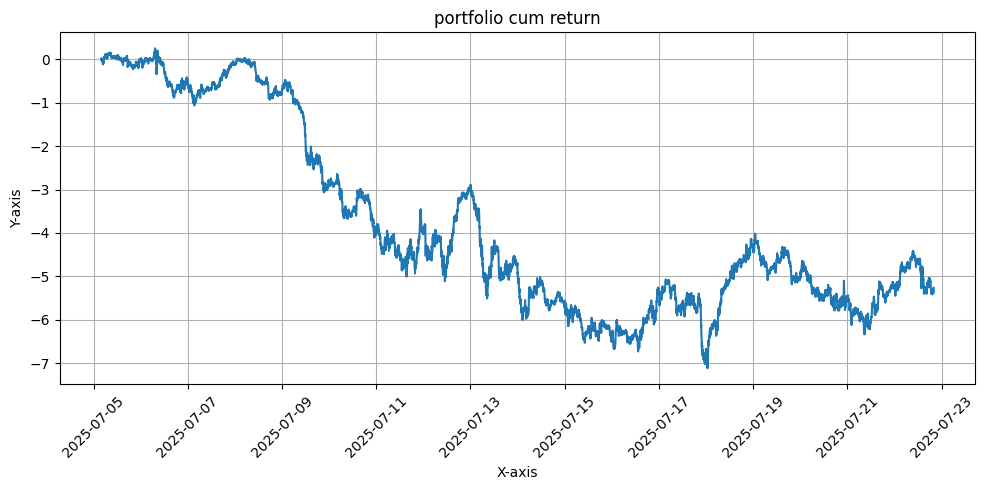

✅ Best model saved.

🔁 Epoch 2/50


Training:   0%|          | 1/1927 [00:00<30:04,  1.07it/s]

  Step 0/1927 - Batch Loss: -0.1744 - Avg Loss: -0.1744


Training:   5%|▌         | 101/1927 [01:32<27:55,  1.09it/s]

  Step 100/1927 - Batch Loss: -0.1440 - Avg Loss: -0.1549


Training:  10%|█         | 201/1927 [03:04<26:23,  1.09it/s]

  Step 200/1927 - Batch Loss: -0.1695 - Avg Loss: -0.1566


Training:  16%|█▌        | 301/1927 [04:36<24:54,  1.09it/s]

  Step 300/1927 - Batch Loss: -0.1518 - Avg Loss: -0.1587


Training:  21%|██        | 401/1927 [06:08<23:20,  1.09it/s]

  Step 400/1927 - Batch Loss: -0.1578 - Avg Loss: -0.1601


Training:  26%|██▌       | 501/1927 [07:40<22:01,  1.08it/s]

  Step 500/1927 - Batch Loss: -0.1744 - Avg Loss: -0.1620


Training:  31%|███       | 601/1927 [09:12<20:17,  1.09it/s]

  Step 600/1927 - Batch Loss: -0.1797 - Avg Loss: -0.1642


Training:  36%|███▋      | 701/1927 [10:44<18:40,  1.09it/s]

  Step 700/1927 - Batch Loss: -0.1944 - Avg Loss: -0.1667


Training:  42%|████▏     | 801/1927 [12:16<17:03,  1.10it/s]

  Step 800/1927 - Batch Loss: -0.1789 - Avg Loss: -0.1690


Training:  47%|████▋     | 901/1927 [13:48<15:44,  1.09it/s]

  Step 900/1927 - Batch Loss: -0.2022 - Avg Loss: -0.1710


Training:  52%|█████▏    | 1001/1927 [15:20<14:18,  1.08it/s]

  Step 1000/1927 - Batch Loss: -0.1938 - Avg Loss: -0.1733


Training:  57%|█████▋    | 1101/1927 [16:53<12:40,  1.09it/s]

  Step 1100/1927 - Batch Loss: -0.1972 - Avg Loss: -0.1757


Training:  62%|██████▏   | 1201/1927 [18:25<11:11,  1.08it/s]

  Step 1200/1927 - Batch Loss: -0.2073 - Avg Loss: -0.1777


Training:  68%|██████▊   | 1301/1927 [19:58<09:38,  1.08it/s]

  Step 1300/1927 - Batch Loss: -0.2205 - Avg Loss: -0.1797


Training:  73%|███████▎  | 1401/1927 [21:30<08:01,  1.09it/s]

  Step 1400/1927 - Batch Loss: -0.2129 - Avg Loss: -0.1819


Training:  78%|███████▊  | 1501/1927 [23:02<06:33,  1.08it/s]

  Step 1500/1927 - Batch Loss: -0.2265 - Avg Loss: -0.1840


Training:  83%|████████▎ | 1601/1927 [24:34<05:01,  1.08it/s]

  Step 1600/1927 - Batch Loss: -0.2260 - Avg Loss: -0.1860


Training:  88%|████████▊ | 1701/1927 [26:07<03:27,  1.09it/s]

  Step 1700/1927 - Batch Loss: -0.1952 - Avg Loss: -0.1879


Training:  93%|█████████▎| 1801/1927 [27:39<01:55,  1.09it/s]

  Step 1800/1927 - Batch Loss: -0.1969 - Avg Loss: -0.1898


Training:  99%|█████████▊| 1901/1927 [29:11<00:23,  1.08it/s]

  Step 1900/1927 - Batch Loss: -0.2602 - Avg Loss: -0.1917


Validating: 100%|██████████| 265/265 [00:32<00:00,  8.19it/s]


📊 Epoch 2 Summary:
  Train Loss: -0.1922
  Val Loss: 0.0122
Mean Return  -4.889092 0.0048885415 0.017412348 -0.02440322
Sharpe  -0.011612458 0.119998164 0.37132266 -0.4413358
Winrate 0.46450471698113205


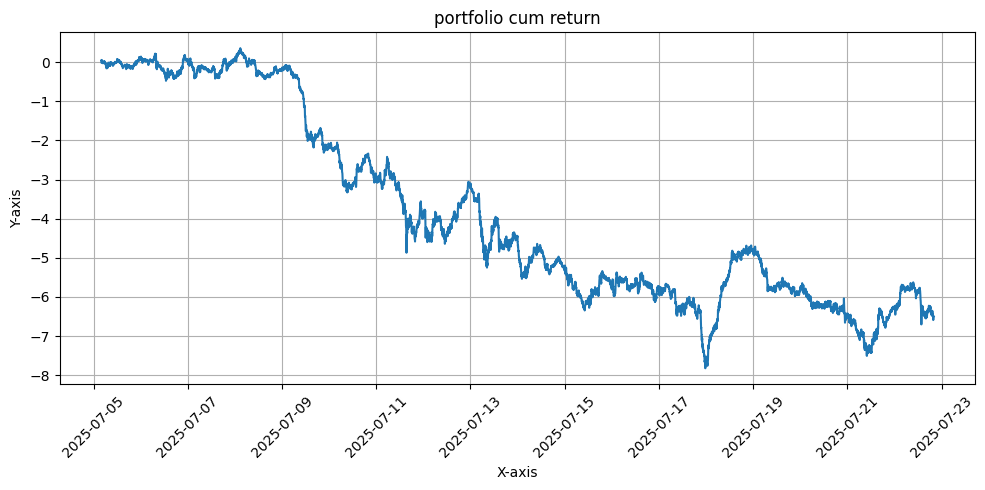

✅ Best model saved.

🔁 Epoch 3/50


Training:   0%|          | 1/1927 [00:00<29:40,  1.08it/s]

  Step 0/1927 - Batch Loss: -0.2569 - Avg Loss: -0.2569


Training:   5%|▌         | 101/1927 [01:33<28:15,  1.08it/s]

  Step 100/1927 - Batch Loss: -0.2422 - Avg Loss: -0.2317


Training:  10%|█         | 201/1927 [03:05<26:33,  1.08it/s]

  Step 200/1927 - Batch Loss: -0.2221 - Avg Loss: -0.2328


Training:  16%|█▌        | 301/1927 [04:37<24:50,  1.09it/s]

  Step 300/1927 - Batch Loss: -0.2315 - Avg Loss: -0.2350


Training:  21%|██        | 401/1927 [06:10<23:35,  1.08it/s]

  Step 400/1927 - Batch Loss: -0.2536 - Avg Loss: -0.2366


Training:  26%|██▌       | 501/1927 [07:42<21:51,  1.09it/s]

  Step 500/1927 - Batch Loss: -0.2288 - Avg Loss: -0.2382


Training:  31%|███       | 601/1927 [09:14<20:08,  1.10it/s]

  Step 600/1927 - Batch Loss: -0.2754 - Avg Loss: -0.2400


Training:  36%|███▋      | 701/1927 [10:46<18:37,  1.10it/s]

  Step 700/1927 - Batch Loss: -0.2424 - Avg Loss: -0.2410


Training:  42%|████▏     | 801/1927 [12:17<17:15,  1.09it/s]

  Step 800/1927 - Batch Loss: -0.2618 - Avg Loss: -0.2427


Training:  47%|████▋     | 901/1927 [13:49<15:38,  1.09it/s]

  Step 900/1927 - Batch Loss: -0.2888 - Avg Loss: -0.2442


Training:  52%|█████▏    | 1001/1927 [15:20<14:10,  1.09it/s]

  Step 1000/1927 - Batch Loss: -0.2600 - Avg Loss: -0.2458


Training:  57%|█████▋    | 1101/1927 [16:52<12:35,  1.09it/s]

  Step 1100/1927 - Batch Loss: -0.2681 - Avg Loss: -0.2470


Training:  62%|██████▏   | 1201/1927 [18:23<11:03,  1.09it/s]

  Step 1200/1927 - Batch Loss: -0.2488 - Avg Loss: -0.2485


Training:  68%|██████▊   | 1301/1927 [19:55<09:33,  1.09it/s]

  Step 1300/1927 - Batch Loss: -0.2767 - Avg Loss: -0.2500


Training:  73%|███████▎  | 1401/1927 [21:26<08:02,  1.09it/s]

  Step 1400/1927 - Batch Loss: -0.2770 - Avg Loss: -0.2513


Training:  78%|███████▊  | 1501/1927 [22:58<06:28,  1.10it/s]

  Step 1500/1927 - Batch Loss: -0.2859 - Avg Loss: -0.2526


Training:  83%|████████▎ | 1601/1927 [24:29<04:58,  1.09it/s]

  Step 1600/1927 - Batch Loss: -0.3005 - Avg Loss: -0.2539


Training:  88%|████████▊ | 1701/1927 [26:01<03:26,  1.09it/s]

  Step 1700/1927 - Batch Loss: -0.2495 - Avg Loss: -0.2552


Training:  93%|█████████▎| 1801/1927 [27:32<01:54,  1.10it/s]

  Step 1800/1927 - Batch Loss: -0.2695 - Avg Loss: -0.2565


Training:  99%|█████████▊| 1901/1927 [29:04<00:23,  1.09it/s]

  Step 1900/1927 - Batch Loss: -0.2763 - Avg Loss: -0.2576


Validating: 100%|██████████| 265/265 [00:32<00:00,  8.14it/s]


📊 Epoch 3 Summary:
  Train Loss: -0.2578
  Val Loss: 0.0063
Mean Return  -3.0174232 0.0042857905 0.014032724 -0.022932619
Sharpe  -0.005798787 0.11617016 0.30848587 -0.45119962
Winrate 0.48797169811320756


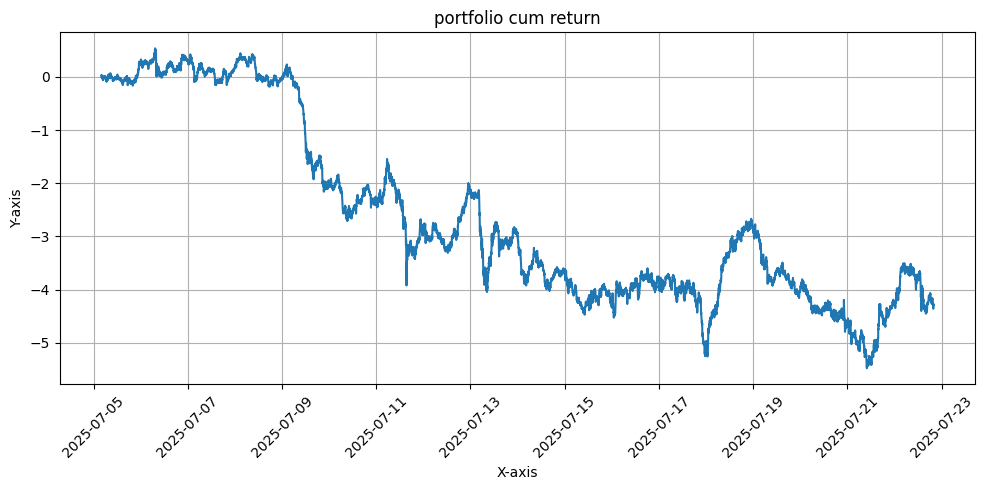

✅ Best model saved.

🔁 Epoch 4/50


Training:   0%|          | 1/1927 [00:00<30:13,  1.06it/s]

  Step 0/1927 - Batch Loss: -0.2921 - Avg Loss: -0.2921


Training:   5%|▌         | 101/1927 [01:32<28:02,  1.09it/s]

  Step 100/1927 - Batch Loss: -0.2922 - Avg Loss: -0.2859


Training:  10%|█         | 201/1927 [03:04<26:22,  1.09it/s]

  Step 200/1927 - Batch Loss: -0.2781 - Avg Loss: -0.2865


Training:  16%|█▌        | 301/1927 [04:37<25:13,  1.07it/s]

  Step 300/1927 - Batch Loss: -0.2827 - Avg Loss: -0.2879


Training:  21%|██        | 401/1927 [06:09<23:25,  1.09it/s]

  Step 400/1927 - Batch Loss: -0.2879 - Avg Loss: -0.2890


Training:  26%|██▌       | 501/1927 [07:42<21:54,  1.08it/s]

  Step 500/1927 - Batch Loss: -0.2719 - Avg Loss: -0.2897


Training:  31%|███       | 601/1927 [09:14<20:13,  1.09it/s]

  Step 600/1927 - Batch Loss: -0.2783 - Avg Loss: -0.2902


Training:  36%|███▋      | 701/1927 [10:46<18:48,  1.09it/s]

  Step 700/1927 - Batch Loss: -0.3140 - Avg Loss: -0.2912


Training:  42%|████▏     | 801/1927 [12:18<17:02,  1.10it/s]

  Step 800/1927 - Batch Loss: -0.3237 - Avg Loss: -0.2917


Training:  47%|████▋     | 901/1927 [13:50<15:44,  1.09it/s]

  Step 900/1927 - Batch Loss: -0.2876 - Avg Loss: -0.2926


Training:  52%|█████▏    | 1001/1927 [15:22<14:14,  1.08it/s]

  Step 1000/1927 - Batch Loss: -0.3097 - Avg Loss: -0.2935


Training:  57%|█████▋    | 1101/1927 [16:54<12:40,  1.09it/s]

  Step 1100/1927 - Batch Loss: -0.3084 - Avg Loss: -0.2943


Training:  62%|██████▏   | 1201/1927 [18:26<11:10,  1.08it/s]

  Step 1200/1927 - Batch Loss: -0.3044 - Avg Loss: -0.2953


Training:  68%|██████▊   | 1301/1927 [19:58<09:34,  1.09it/s]

  Step 1300/1927 - Batch Loss: -0.3055 - Avg Loss: -0.2962


Training:  73%|███████▎  | 1401/1927 [21:30<08:06,  1.08it/s]

  Step 1400/1927 - Batch Loss: -0.3251 - Avg Loss: -0.2971


Training:  78%|███████▊  | 1501/1927 [23:02<06:31,  1.09it/s]

  Step 1500/1927 - Batch Loss: -0.2988 - Avg Loss: -0.2980


Training:  83%|████████▎ | 1601/1927 [24:35<05:00,  1.08it/s]

  Step 1600/1927 - Batch Loss: -0.3109 - Avg Loss: -0.2990


Training:  88%|████████▊ | 1701/1927 [26:07<03:29,  1.08it/s]

  Step 1700/1927 - Batch Loss: -0.3348 - Avg Loss: -0.2998


Training:  93%|█████████▎| 1801/1927 [27:39<01:56,  1.08it/s]

  Step 1800/1927 - Batch Loss: -0.3221 - Avg Loss: -0.3005


Training:  99%|█████████▊| 1901/1927 [29:11<00:23,  1.09it/s]

  Step 1900/1927 - Batch Loss: -0.3141 - Avg Loss: -0.3014


Validating: 100%|██████████| 265/265 [00:33<00:00,  7.86it/s]


📊 Epoch 4 Summary:
  Train Loss: -0.3015
  Val Loss: 0.0074
Mean Return  -2.8545482 0.0038957486 0.014826558 -0.017856026
Sharpe  -0.0068510794 0.11526024 0.33240312 -0.42073408
Winrate 0.4863207547169811


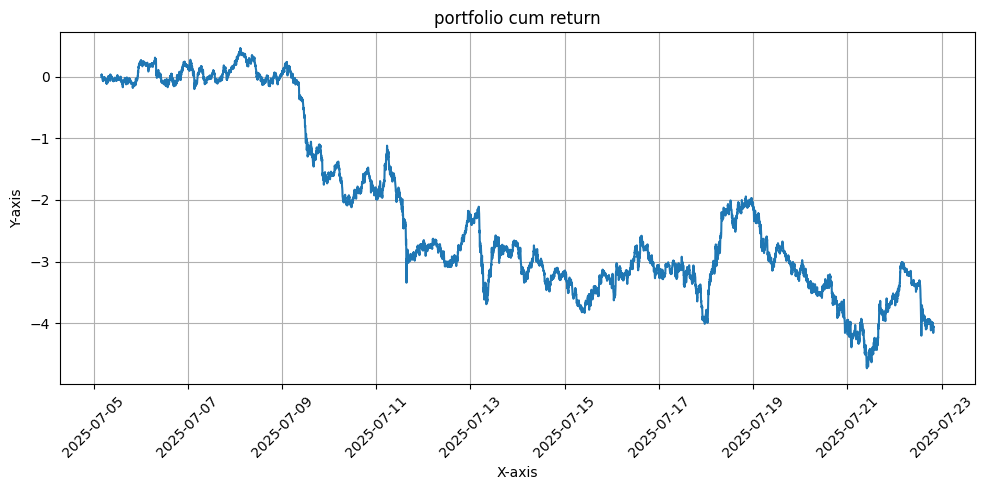

⏳ Early stopping patience: 1/5

🔁 Epoch 5/50


Training:   0%|          | 1/1927 [00:00<29:54,  1.07it/s]

  Step 0/1927 - Batch Loss: -0.2950 - Avg Loss: -0.2950


Training:   5%|▌         | 101/1927 [01:33<28:03,  1.08it/s]

  Step 100/1927 - Batch Loss: -0.3312 - Avg Loss: -0.3208


Training:  10%|█         | 201/1927 [03:05<26:26,  1.09it/s]

  Step 200/1927 - Batch Loss: -0.3195 - Avg Loss: -0.3208


Training:  16%|█▌        | 301/1927 [04:37<24:48,  1.09it/s]

  Step 300/1927 - Batch Loss: -0.3046 - Avg Loss: -0.3220


Training:  21%|██        | 401/1927 [06:08<23:21,  1.09it/s]

  Step 400/1927 - Batch Loss: -0.3484 - Avg Loss: -0.3229


Training:  26%|██▌       | 501/1927 [07:40<21:47,  1.09it/s]

  Step 500/1927 - Batch Loss: -0.3329 - Avg Loss: -0.3236


Training:  31%|███       | 601/1927 [09:12<20:08,  1.10it/s]

  Step 600/1927 - Batch Loss: -0.3266 - Avg Loss: -0.3245


Training:  36%|███▋      | 701/1927 [10:44<19:01,  1.07it/s]

  Step 700/1927 - Batch Loss: -0.3248 - Avg Loss: -0.3256


Training:  42%|████▏     | 801/1927 [12:16<17:40,  1.06it/s]

  Step 800/1927 - Batch Loss: -0.3125 - Avg Loss: -0.3259


Training:  47%|████▋     | 901/1927 [13:48<15:34,  1.10it/s]

  Step 900/1927 - Batch Loss: -0.3085 - Avg Loss: -0.3267


Training:  52%|█████▏    | 1001/1927 [15:20<14:10,  1.09it/s]

  Step 1000/1927 - Batch Loss: -0.3283 - Avg Loss: -0.3274


Training:  57%|█████▋    | 1101/1927 [16:51<12:42,  1.08it/s]

  Step 1100/1927 - Batch Loss: -0.3253 - Avg Loss: -0.3279


Training:  62%|██████▏   | 1201/1927 [18:23<10:59,  1.10it/s]

  Step 1200/1927 - Batch Loss: -0.3493 - Avg Loss: -0.3286


Training:  68%|██████▊   | 1301/1927 [19:54<09:26,  1.10it/s]

  Step 1300/1927 - Batch Loss: -0.3390 - Avg Loss: -0.3293


Training:  72%|███████▏  | 1378/1927 [21:05<08:24,  1.09it/s]


KeyboardInterrupt: 

In [44]:
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch
import numpy as np
import os

def compute_r2_per_stock(y_true, y_pred):
    r2s = []
    for i in range(y_true.shape[1]):
        r2s.append(r2_score(y_true[:, i], y_pred[:, i]))
    return r2s

num_epochs=50
patience=5
save_path='/content/drive/MyDrive/portfolio_novo/model_mofn_3min_perp_ls_nofn.pth'
device='cuda'
# top_k = 10

best_val_loss = float('inf')
patience_counter = 0

model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model.to(device)
print('Len of selected stock is :',(top_k))
for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_loss = 0

    print(f"\n🔁 Epoch {epoch}/{num_epochs}")
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        ts_input = batch['timeseries'].cuda()
        news_input = batch['news'].cuda()
        target = batch['target'].cuda()
        news_count = batch['news_count'].cuda()
        time_mask = 1 #batch['time_mask'].to(device)

        output = model(ts_input, news_count,news_input, time_mask)
        # loss = loss_topm(output, target, m=top_k, lambda_div=0.01)
        loss = loss_topk_longshort(output, target, k=top_k, gross=1.0, use_cov=True, lambda_div=0.01, lambda_net=0, lambda_turnover=0,  prev_w=None, eps=1e-6)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        # Step-wise print every 100 steps
        if step % 100 == 0:
            avg_loss = total_train_loss / (step + 1)
            print(f"  Step {step}/{len(train_loader)} - Batch Loss: {loss.item():.4f} - Avg Loss: {avg_loss:.4f}")


    # Validation phase
    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []
    all_return, all_sharp = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            ts_input = batch['timeseries'].cuda()
            news_input = batch['news'].cuda()
            target = batch['target'].cuda()
            news_count = batch['news_count'].cuda()
            time_mask = 1 #batch['time_mask'].to(device)

            output = model(ts_input, news_count,news_input, time_mask)
            loss = loss_topk_longshort(output, target, k=top_k, gross=1.0, use_cov=True, lambda_div=0.01, lambda_net=0, lambda_turnover=0,  prev_w=None, eps=1e-6)
            # Validation
            mean_r, sharpe, w = validate_longshort(output, target, k=top_k, gross=1.0, use_cov=True)
            total_val_loss += loss.item()
            all_preds.append(w.cpu().numpy())
            all_targets.append(target.cpu().numpy())
            all_return.extend(mean_r.cpu().numpy())
            all_sharp.extend(sharpe.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # y_pred = np.concatenate(all_preds, axis=0)
    # y_true = np.concatenate(all_targets, axis=0)
    # r2_scores = compute_r2_per_stock(y_true, y_pred)

    print(f"📊 Epoch {epoch} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print("Mean Return ", np.sum(all_return), np.std(all_return), np.max(all_return), np.min(all_return))
    print("Sharpe ", np.mean(all_sharp), np.std(all_sharp), np.max(all_sharp), np.min(all_sharp))
    print('Winrate', sum([1 for x in all_return if x>0])/len(all_return))
    # print("  R² per stock:", ["{} , {:.3f}".format(list_crypto_first[r], r2_scores[r]) for r in range(len(r2_scores))])

    df_portfolio = func_generate_portfolio(all_preds, data_portfo=data_val, seq_len=my_seq_len)
    # if epoch % 5 == 0:
    #     np.save(f"y_pred_epoch_{epoch}.npy", y_pred)
    #     np.save(f"y_true_epoch_{epoch}.npy", y_true)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print("✅ Best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Early stopping patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("⛔ Early stopping triggered.")
        break


In [ ]:
abs(df_portfolio[[x for x in df_portfolio.columns if 'weight' in x]]).sum()

,0
BTCUSDT_weight,449.202332
ETHUSDT_weight,581.486084
XRPUSDT_weight,476.824799
SOLUSDT_weight,325.183502
DOGEUSDT_weight,293.936707
ADAUSDT_weight,267.711975
TRUMPUSDT_weight,65.529106
SHIBUSDT_weight,157.851395
BNBUSDT_weight,384.979095
USDCUSDT_weight,344.653870


Load best model and test on Test Data

In [ ]:
model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=shifted_window,
 d_model=64, nhead=4, num_layers=2).to(device)

# save_path = '/content/drive/MyDrive/Portfolio/best_model_10of10_v1_30min.pth'
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()  # Important: Set model to evaluation mode


input_sample = torch.randn(1, shifted_window, len(selected_f_all)).to(device)

def forecast(input_sample):
    model.eval()
    with torch.no_grad():
        input_sample = input_sample.to(device)
        output = model(input_sample, 1)
    return output.cpu().numpy()

forecast(input_sample)

Validating: 100%|██████████| 292/292 [00:38<00:00,  7.58it/s]


📊 Epoch 0 Summary:
  Val Loss: -0.0029
Mean Return  0.9223327 0.0025788553 0.010284105 -0.010427347
Sharpe  0.0031819155 0.101627015 0.39734235 -0.34685835
Winrate 0.5181458087999143


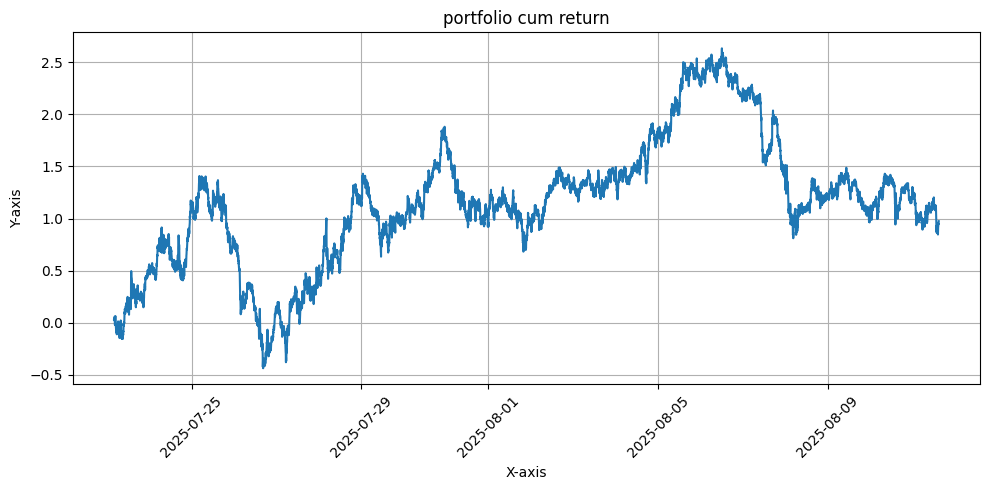

In [52]:
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch
import numpy as np
import os
epoch = 0

# Validation phase
model.eval()
total_val_loss = 0
all_preds, all_targets = [], []
all_return, all_sharp = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Validating"):
        ts_input = batch['timeseries'].cuda()
        news_input = batch['news'].cuda()
        target = batch['target'].cuda()
        news_count = batch['news_count'].cuda()
        time_mask = 1 #batch['time_mask'].to(device)

        output = model(ts_input, news_count,news_input, time_mask)
        loss = loss_topk_longshort(output, target, k=top_k, gross=1.0, use_cov=True, lambda_div=0.01, lambda_net=1e-3, lambda_turnover=1e-2,  prev_w=None, eps=1e-6)
        # Validation
        mean_r, sharpe, w = validate_longshort(output, target, k=top_k, gross=1.0, use_cov=True)
        total_val_loss += loss.item()
        all_preds.append(w.cpu().numpy())
        all_targets.append(target.cpu().numpy())
        all_return.extend(mean_r.cpu().numpy())
        all_sharp.extend(sharpe.cpu().numpy())

avg_val_loss = total_val_loss / len(val_loader)

# y_pred = np.concatenate(all_preds, axis=0)
# y_true = np.concatenate(all_targets, axis=0)
# r2_scores = compute_r2_per_stock(y_true, y_pred)

print(f"📊 Epoch {epoch} Summary:")
print(f"  Val Loss: {avg_val_loss:.4f}")
print("Mean Return ", np.sum(all_return), np.std(all_return), np.max(all_return), np.min(all_return))
print("Sharpe ", np.mean(all_sharp), np.std(all_sharp), np.max(all_sharp), np.min(all_sharp))
print('Winrate', sum([1 for x in all_return if x>0])/len(all_return))
# print("  R² per stock:", ["{} , {:.3f}".format(list_crypto_first[r], r2_scores[r]) for r in range(len(r2_scores))])

df_portfolio = func_generate_portfolio(all_preds, data_portfo=data_test, seq_len=my_seq_len)

In [48]:
df_portfolio.to_csv('df_portfolio_concat_30of30.csv')

In [ ]:
top_k

Extra Codes

Validating: 100%|██████████| 670/670 [02:24<00:00,  4.64it/s]


Val Loss: -0.0223
Mean Return  30.26249677913819 0.011491857661613956 0.11728161573410034 -0.07462553679943085
Sharpe  0.025740532536779732 0.18040939377568016 0.9108314514160156 -0.6701962947845459
Winrate 0.5597014925373134
Closed to cash: 7455/21440 (34.8%)


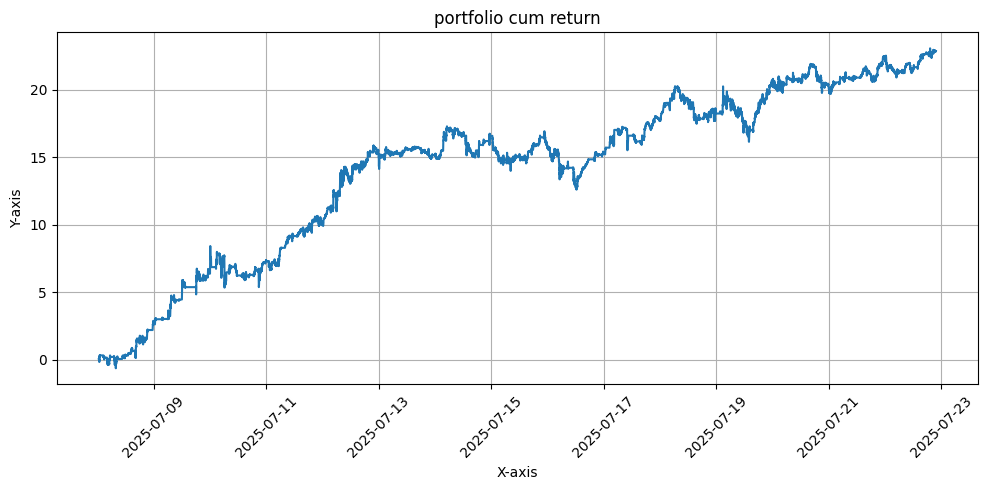

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# --- helpers ---
def logits_to_weights(logits, eps=1e-8):
    w = torch.sigmoid(logits)
    return w / (w.sum(dim=1, keepdim=True) + eps)

def entropy_and_margin(logits, eps=1e-9):
    p = F.softmax(logits, dim=1)                       # [B,N]
    ent = -(p.clamp_min(eps) * p.clamp_min(eps).log()).sum(dim=1)  # [B]
    top2 = torch.topk(p, k=2, dim=1).values            # [B,2]
    margin = top2[:, 0] - top2[:, 1]                   # [B]
    return ent, margin

@torch.no_grad()
def mc_dropout_weight_uncertainty(model, ts_input, passes=30):
    """
    Runs MC-dropout WITHOUT touching future returns.
    Returns:
      w_mean [B,N], w_std [B,N], logit_std [B,N]
    """
    model.train()   # keep dropout ON
    W, L = [], []
    for _ in range(passes):
        output = model(ts_input, time_mask)
        loss = loss_topm(output, target, m=top_k, lambda_div=0.01)
        mean_r, sharpe, w = validate_topm(output, target, m=top_k)

        W.append(w)
        L.append(output)
    model.eval()

    W = torch.stack(W, dim=0)          # [S,B,N]
    L = torch.stack(L, dim=0)          # [S,B,N]
    return W.mean(0), W.std(0), L.std(0)
# --------- VALIDATION WITH UNCERTAINTY GATE ----------
epoch = 0
model.eval()

# thresholds (tune these)
ENTROPY_MAX = 1.8       # higher -> more tolerant to uncertainty
MARGIN_MIN  = 0.2      # lower  -> more tolerant to uncertainty
FEE_RATE    = 0.0       # set >0 if you want to account for fees in gating
MC_PASSES   = 30         # e.g., 30 to enable MC-dropout; 0 disables it
Z_SCORE     = 1.64      # one-sided ~95% for mean - z*std

total_val_loss = 0.0
all_return, all_sharp = [], []
closed_count = 0
total_rows = 0

all_w = []
all_ent, all_margin, all_ret_mu, all_ret_sigma, all_risk_adj, all_fee_vec = [], [], [], [], [], []
all_w_final = []
all_mask = []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        ts_input = batch['timeseries'].to(device)
        target   = batch['target'].to(device)          # [B,T,N]

        # raw logits
        output = model(ts_input, time_mask)
        loss = loss_topm(output, target, m=top_k, lambda_div=0.01)
        mean_r, sharpe, w = validate_topm(output, target, m=top_k)

        # your original loss (if you still want to track it)
        total_val_loss += loss.item()

        # Example inside your val loop (no target used for uncertainty):
        w_mean, w_std, logit_std = mc_dropout_weight_uncertainty(model, ts_input, passes=30)
        ent, mar = entropy_and_margin(output)

        # simple gate (tune thresholds on a holdout):
        close_mask = (ent > 2.5) | (mar < 0.015) | (w_std.sum(1) > 0.25)

        # base weights (no turnover)
        # w = logits_to_weights(logits)                  # [B,N]
        # pr = (w.unsqueeze(1) * target).sum(dim=2)      # [B,T]

        all_mask.extend(close_mask.cpu().numpy().tolist())
        # apply gate: move to cash (all zeros) for closed rows
        w_final = w.clone()
        w_final[close_mask] = 0.0

        # portfolio returns with gated weights
        pr_final = (w.unsqueeze(1) * target).sum(dim=2)  # [B,T]
        mean_r   = pr_final.mean(dim=1)                        # [B]
        std_r    = pr_final.std(dim=1) + 1e-6                  # [B]
        sharpe   = mean_r / std_r

        all_return.extend(mean_r.cpu().numpy().tolist())
        all_sharp.extend(sharpe.cpu().numpy().tolist())
        all_w.extend(w.cpu().numpy().tolist())
        all_w_final.extend(w_final.cpu().numpy().tolist())
        all_ent.extend(ent.cpu().numpy().tolist())
        all_margin.extend(mar.cpu().numpy().tolist())
        all_ret_sigma.extend(w_std.sum(1).cpu().numpy().tolist())

        closed_count += close_mask.sum().item()
        total_rows   += close_mask.numel()

avg_val_loss = total_val_loss / max(1, len(val_loader))
print(f"Val Loss: {avg_val_loss:.4f}")
print("Mean Return ", np.sum(all_return), np.std(all_return), np.max(all_return), np.min(all_return))
print("Sharpe ", np.mean(all_sharp), np.std(all_sharp), np.max(all_sharp), np.min(all_sharp))
print('Winrate', sum(1 for x in all_return if x > 0) / max(1, len(all_return)))
print(f"Closed to cash: {closed_count}/{total_rows} ({100.0*closed_count/max(1,total_rows):.1f}%)")
df_portfolio = func_generate_portfolio2(all_w_final)

<Axes: xlabel='dateTime'>

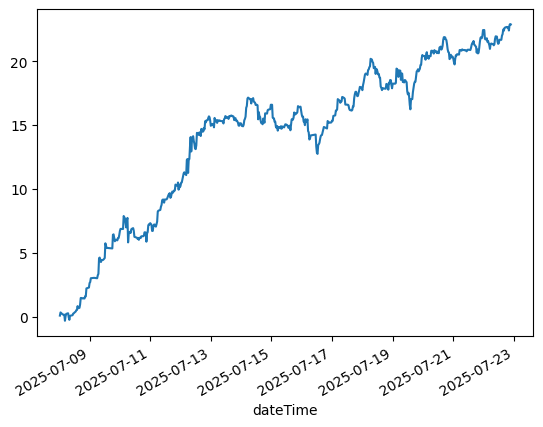

In [ ]:
df_portfo2 = df_portfolio.iloc[::30].reset_index().drop('index',axis=1)
df_portfo2[~(df_portfo2['portfolio'].diff()==0)].set_index('dateTime')['portfolio'].plot()

In [ ]:
df_portfolio[~(df_portfolio['portfolio'].diff()==0)]['portfolio'].diff().mean()/df_portfolio[~(df_portfolio['portfolio'].diff()==0)]['portfolio'].diff().std()

np.float64(0.02148567157451018)

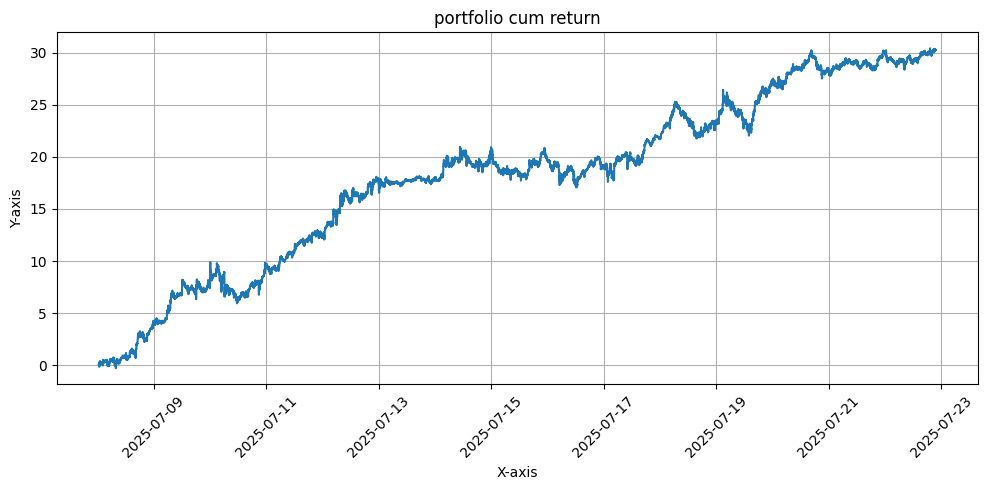

In [ ]:
df_portfolio = func_generate_portfolio2(all_w)

In [ ]:
import matplotlib.pyplot as plt

only_top_k = False
# len(self.df) - self.seq_len-shifted_window
predicted_array = np.vstack(all_preds)

df_weight_pred = data_test[30:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()

df_return = data_test[30:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()
list_weight = []
for i in range(len(list_crypto)):
  df_weight_pred[list_crypto[i]+'_weight'] = predicted_array[:,i]
  list_weight.append(list_crypto[i]+'_weight')

sum_weight = abs(df_weight_pred[list_weight]).sum(axis=1).copy()
for x in list_weight:
  df_weight_pred[x] = df_weight_pred[x]/sum_weight

df_weight_30 = df_weight_pred[['dateTime']+list(df_weight_pred.columns[-len(list_weight):])].iloc[::30].reset_index().drop('index',axis=1)
df_portfolio = df_return.merge(df_weight_30, on='dateTime', how='left')

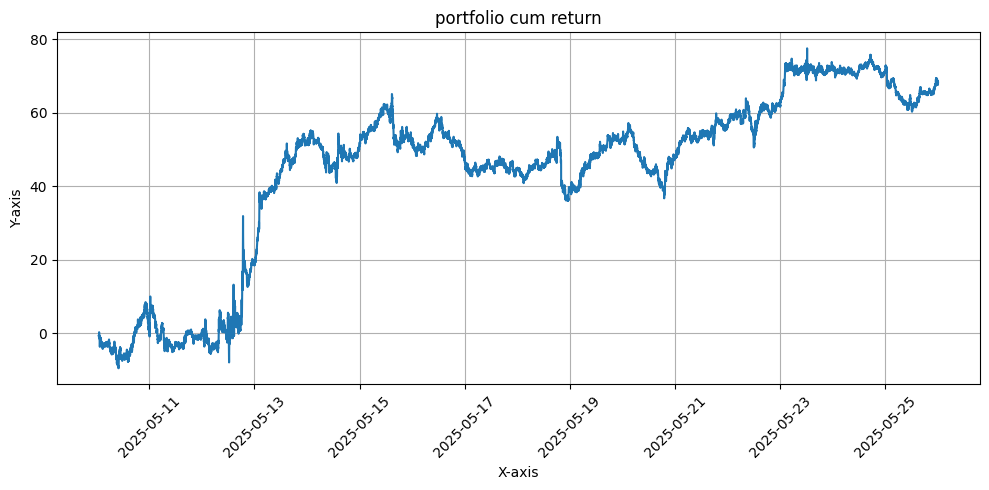

In [ ]:
import matplotlib.pyplot as plt

only_top_k = False
# len(self.df) - self.seq_len-shifted_window
predicted_array = np.vstack(all_preds)

df_weight_pred = data_test[30:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()

df_return = data_test[30:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()
list_weight = []
for i in range(len(list_crypto)):
  df_weight_pred[list_crypto[i]+'_weight'] = predicted_array[:,i]
  list_weight.append(list_crypto[i]+'_weight')

sum_weight = abs(df_weight_pred[list_weight]).sum(axis=1).copy()
for x in list_weight:
  df_weight_pred[x] = df_weight_pred[x]/sum_weight

df_weight_30 = df_weight_pred[['dateTime']+list(df_weight_pred.columns[-len(list_weight):])].iloc[::30].reset_index().drop('index',axis=1)
df_portfolio = df_return.merge(df_weight_30, on='dateTime', how='left')
df_portfolio = df_portfolio.fillna(method='ffill')
list_portfolio = []
for x in list_crypto:
  df_portfolio[x+'_value'] = df_portfolio[x+'_weight']*df_portfolio[x+'_return']
  list_portfolio.append(x+'_value')
df_portfolio['portfolio'] = df_portfolio[list_portfolio].cumsum().sum(axis=1)


# Example: Plot df['y'] vs df['x']
plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(df_portfolio['dateTime'], df_portfolio['portfolio'])  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('my_figure.png', dpi=300)  # or .jpg, .svg, .pdf

plt.show()

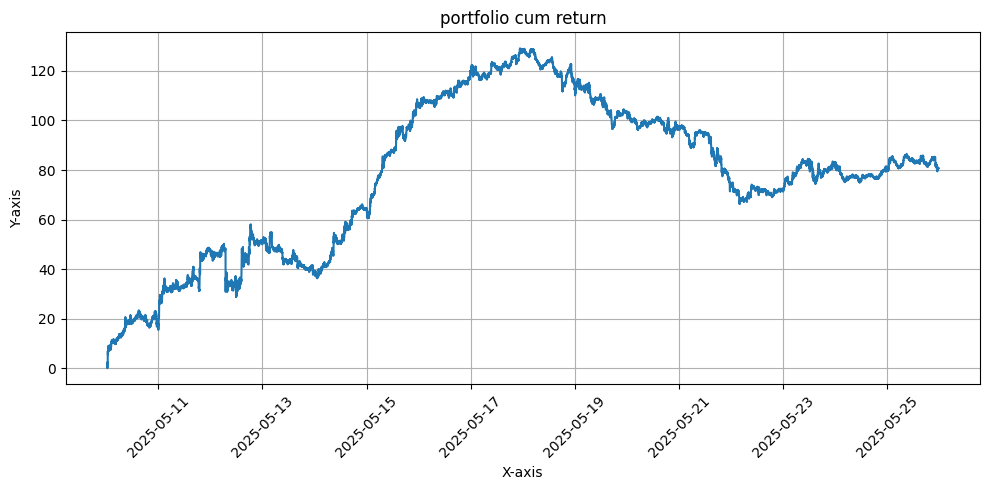

In [ ]:
import matplotlib.pyplot as plt

only_top_k = False
# len(self.df) - self.seq_len-shifted_window
predicted_array = np.vstack(all_preds)
lowest_value = np.vstack(all_topk_vals)
df_weight_pred = data_test[30:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()
df_weight_pred ['lowest_value'] = lowest_value[:,-1]
df_return = data_test[30:-shifted_window][['dateTime']+[x+'_return' for x in list_crypto]].copy()
list_weight = []
for i in range(len(list_crypto)):
  df_weight_pred[list_crypto[i]+'_weight'] = predicted_array[:,i]
  list_weight.append(list_crypto[i]+'_weight')

if(only_top_k):
  for x in list_weight:
    df_weight_pred.loc[abs(df_weight_pred[x])<df_weight_pred['lowest_value'], x] = 0

sum_weight = abs(df_weight_pred[list_weight]).sum(axis=1).copy()
for x in list_weight:
  df_weight_pred[x] = df_weight_pred[x]/sum_weight

df_weight_30 = df_weight_pred[['dateTime']+list(df_weight_pred.columns[-len(list_weight):])].iloc[::30].reset_index().drop('index',axis=1)
df_portfolio = df_return.merge(df_weight_30, on='dateTime', how='left')
df_portfolio = df_portfolio.fillna(method='ffill')
list_portfolio = []
for x in list_crypto:
  df_portfolio[x+'_value'] = df_portfolio[x+'_weight']*df_portfolio[x+'_return']
  list_portfolio.append(x+'_value')
df_portfolio['portfolio'] = df_portfolio[list_portfolio].cumsum().sum(axis=1)


# Example: Plot df['y'] vs df['x']
plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(df_portfolio['dateTime'], df_portfolio['portfolio'])  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('my_figure.png', dpi=300)  # or .jpg, .svg, .pdf

plt.show()

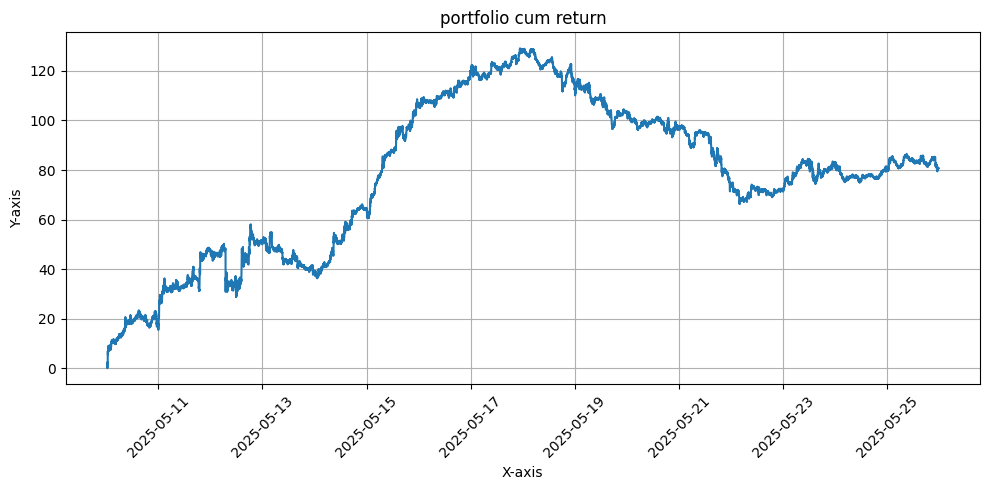

<Axes: >

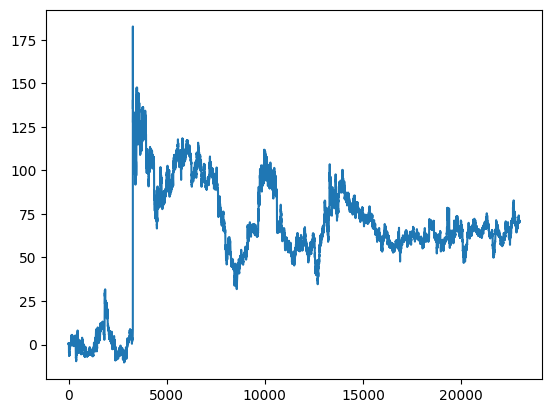

In [ ]:
df_portfolio['OGUSDT_return'].cumsum().plot()

<Axes: >

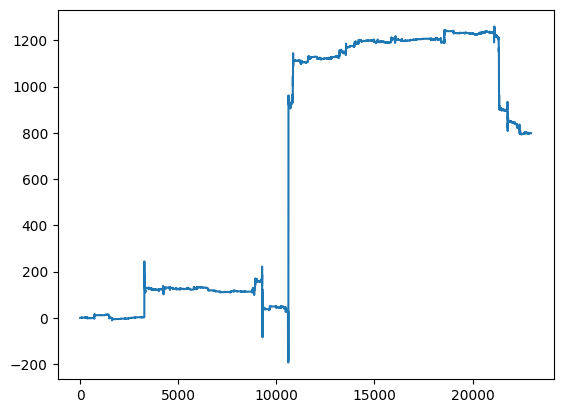

In [ ]:
df_portfolio['OGUSDT_value'].cumsum().plot()

<Axes: >

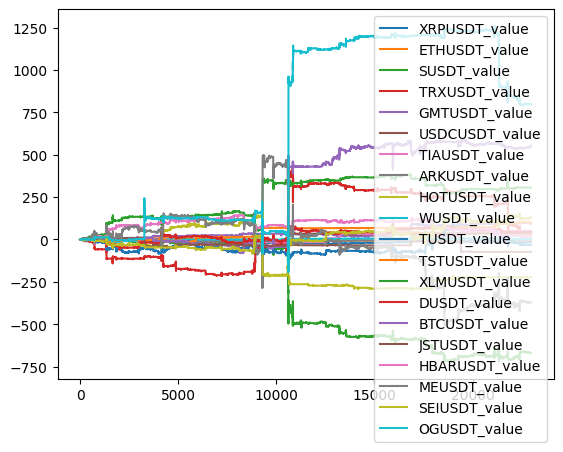

In [ ]:
df_portfolio[list_portfolio].cumsum().plot()

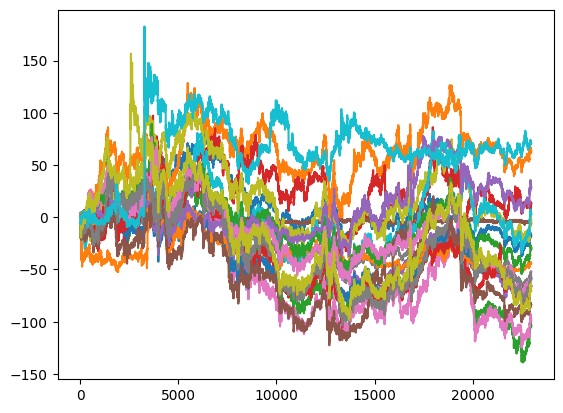

In [ ]:
# df_portfolio['ETHUSDT'+'_return'].cumsum().plot()

for x in list_crypto:
  df_portfolio[x+'_return'].cumsum().plot()

In [ ]:
df_weight_pred.to_pickle('/content/drive/MyDrive/Portfolio/10stock_df_weight_pred.pickle')

<Axes: >

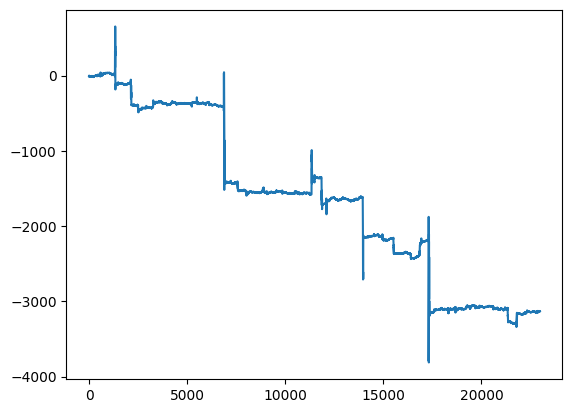

In [ ]:
df_weight_30 = df_weight_pred[['dateTime']+list(df_weight_pred.columns[-len(list_weight):])].iloc[::30].reset_index().drop('index',axis=1)
df_portfolio = df_return.merge(df_weight_30, on='dateTime', how='left')
df_portfolio = df_portfolio.fillna(method='ffill')
list_portfolio = []
for x in list_crypto:
  df_portfolio[x+'_value'] = df_portfolio[x+'_weight']*df_portfolio[x+'_return']
  list_portfolio.append(x+'_value')
df_portfolio[list_portfolio].cumsum().sum(axis=1).plot()

In [ ]:
df_portfolio.to_pickle('/content/drive/MyDrive/Portfolio/10stock_df_portfolio.pickle')

In [ ]:
df_portfolio.to_pickle

In [ ]:
(df_portfolio[list_portfolio].sum(axis=1).iloc[::30]>0).sum()/len((df_portfolio[list_portfolio].sum(axis=1).iloc[::30]>0))

np.float64(0.5032594524119948)

In [ ]:
np.sum((output.cpu().numpy()<0), axis=0)

array([10, 13, 14, 13, 12, 28, 20, 17, 30,  7])

In [ ]:
np.sum((output.cpu().numpy()>0), axis=0)

array([22, 19, 18, 19, 20,  4, 12, 15,  2, 25])

In [ ]:
# Validation phase
model.eval()
total_val_loss = 0
all_preds, all_targets = [], []
all_return, all_sharp = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        ts_input = batch['timeseries'].to(device)
        news_input = batch['news'].to(device)
        target = batch['target'].to(device)
        time_mask = 1 #batch['time_mask'].to(device)

        output = model(ts_input, time_mask, news_input)
        loss = func_loss(output, target)
        mean_r, sharp = func_validation(output, target)
        total_val_loss += loss.item()
        all_preds.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())
        all_return.extend(mean_r.cpu().numpy())
        all_sharp.extend(sharp.cpu().numpy())

avg_train_loss = total_train_loss / len(train_loader)
avg_val_loss = total_val_loss / len(val_loader)

# y_pred = np.concatenate(all_preds, axis=0)
# y_true = np.concatenate(all_targets, axis=0)
# r2_scores = compute_r2_per_stock(y_true, y_pred)

print(f"📊 Epoch {epoch} Summary:")
print(f"  Train Loss: {avg_train_loss:.4f}")
print(f"  Val Loss: {avg_val_loss:.4f}")
print("Mean Return ", np.sum(all_return), np.mean(all_return), np.max(all_return), np.min(all_return))
print("Sharpe ", np.mean(all_sharp), np.mean(all_sharp), np.max(all_sharp), np.min(all_sharp))
print('Winrate', sum([1 for x in all_return if x>0])/len(all_return))
# print("  R² per stock:", ["{} , {:.3f}".format(list_crypto_first[r], r2_scores[r]) for r in range(len(r2_scores))])

# if epoch % 5 == 0:
#     np.save(f"y_pred_epoch_{epoch}.npy", y_pred)
#     np.save(f"y_true_epoch_{epoch}.npy", y_true)

if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    patience_counter = 0
    torch.save(model.state_dict(), save_path)
    print("✅ Best model saved.")
else:
    patience_counter += 1
    print(f"⏳ Early stopping patience: {patience_counter}/{patience}")

if patience_counter >= patience:
    print("⛔ Early stopping triggered.")
    break

Validating: 100%|██████████| 719/719 [01:19<00:00,  9.06it/s]

📊 Epoch 1 Summary:
  Train Loss: -0.0003
  Val Loss: -0.0067
Mean Return  51.214542 0.0022285602 0.2783696 -0.5163537
Sharpe  0.0071198954 0.0071198954 0.69474566 -0.77679485
Winrate 0.5131195335276968
⏳ Early stopping patience: 2/5


SyntaxError: 'break' outside loop (ipython-input-154-4172301505.py, line 53)

In [ ]:
sum([1 for x in all_return if x>0])/len(all_return)

0.5131195335276968